In [1]:
# Import necessary packages

import numpy as np
import opendssdirect as dss
# from utils.device.Inverter import Inverter
# from utils.controller.AdaptiveInvController import AdaptiveInvController
# from utils.controller.FixedInvController import FixedInvController
import matplotlib.pyplot as plt
from math import tan,acos
import copy
import pandas as pd
import time

from collections import deque
import signal_processing as signal_processing

# import numpy as np
# from matplotlib.mlab import PCA
# from sklearn.decomposition import PCA

import scipy.linalg as spla

In [2]:
# Set global variables and parameters, and test OpenDSS with network


#######################################################
###Global variable initialization and error checking###
#######################################################

Sbase=1
LoadScalingFactor = 3
GenerationScalingFactor = 5
SlackBusVoltage = 1.00
NoiseMultiplyer= 1
#Set simulation analysis period - the simulation is from StartTime to EndTime
StartTime = 40600
EndTime = StartTime + 640
EndTime += 1 # creating a list, last element does not count, so we increase EndTime by 1
#Set hack parameters
TimeStepOfHack = 160
PercentHacked = np.array([0,0,0,0,0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set initial VBP parameters for uncompromised inverters
VBP_normal=np.array([0.97, 1, 1, 1.03, 1.06])
VBP_attack=np.array([0.997, 1, 1, 1.003, 1.007])

#Set delays for each node
Delay_VBPCurveShift = (30+2*np.random.randn(31)).astype(int)
#Delay_VBPCurveShift = (10+2*np.random.randn(31)).astype(int)
lpf_meas_vector = (1+0.2*np.random.randn(31))
lpf_output_vector= (0.1+0.015*np.random.randn(31))

#Set observer voltage threshold
ThreshHold_vqvp = 0.06
adaptive_gain=800


power_factor=0.9
pf_converted=tan(acos(power_factor))
# Number_of_Inverters = 13 #even feeder is 34Bus, we only have 13 inverters


#Error checking of the global variable -- TODO: add error handling here!
if EndTime < StartTime or EndTime < 0 or StartTime < 0:
    print('Setup Simulation Times Inappropriately.')
if NoiseMultiplyer < 0:
    print('Setup Noise Multiplyer Correctly.')

# Select OpenDSS file
dss.run_command('Redirect 05node_singlephase_balanced_oscillation_02.dss')

# Solve power flow with OpenDSS file
dss.Solution.Solve()
if not dss.Solution.Converged:
    print('Initial Solution Not Converged. Check Model for Convergence')
else:
    print('Initial Model Converged. Proceeding to Next Step.')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    dss.Monitors.ResetAll()
    
    #set solution Params
    #setSolutionParams(dss,'daily',1,1,'off',1000000,30000)
    dss.Solution.Mode(1)
    dss.Solution.Number(1)
    dss.Solution.StepSize(1)
    dss.Solution.ControlMode(-1)
    dss.Solution.MaxControlIterations(1000000)
    dss.Solution.MaxIterations(30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=dss.Loads.Count()
    AllLoadNames=dss.Loads.AllNames()
    print('OpenDSS Model Compliation Done.')

print('')

# Print number of buses, and bus names
print(len(dss.Circuit.AllBusNames()))
print(dss.Circuit.AllBusNames())

# Print number of loads, and load names
print(len(dss.Loads.AllNames()))
print(dss.Loads.AllNames())

print('')

# Print different voltage measurements
for k1 in range(len(dss.Circuit.AllBusNames())):
    if dss.Circuit.AllBusNames()[k1] == 'sourcebus':
        dss.Circuit.SetActiveBus(dss.Circuit.AllBusNames()[k1])
        
        print(dss.Circuit.AllBusNames()[k1])
        print('BASE - LN')
        print(dss.Bus.kVBase())
        print('VMAGANGLE - LN POLAR')
        print(dss.Bus.VMagAngle())
        print('puVMAGANGLE - LN POLAR')
        print(dss.Bus.puVmagAngle())
        print('VOTLAGES - LN CARTESIAN')
        print(dss.Bus.Voltages())
        print('puVOTLAGES - LN CARTESIAN')
        print(dss.Bus.PuVoltage())
        print('VLL - LL CARTESIAN')
        print(dss.Bus.VLL())
        print('puVLL - LL CARTESIAN')
        print(dss.Bus.puVLL())
        
        tempvoltage = dss.Bus.Voltages()
        
        Vab = tempvoltage[0]
        
print('')
        
for k1 in range(len(dss.Circuit.AllBusNames())):
    dss.Circuit.SetActiveBus(dss.Circuit.AllBusNames()[k1])
    print(dss.Circuit.AllBusNames()[k1])
    print('BASE - LN')
    print(dss.Bus.kVBase())
    print('VMAGANGLE - LN POLAR')
    print(dss.Bus.VMagAngle())
    print('puVMAGANGLE - LN POLAR')
    print(dss.Bus.puVmagAngle())
    print('')

    
# dir(dss.Bus)

Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.

7
['sourcebus', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06']
4
['load_a02_a', 'load_a03_a', 'load_a04_a', 'load_a06_a']

sourcebus
BASE - LN
132.79056191361394
VMAGANGLE - LN POLAR
[132790.3305170153, -0.0001433853292641436, 132790.54102140915, -120.0000034617439, 132790.57934672132, 119.99999393381263]
puVMAGANGLE - LN POLAR
[0.9999982574318891, -0.0001433853292641436, 0.9999998426679994, -120.0000034617439, 1.0000001312827294, 119.99999393381263]
VOTLAGES - LN CARTESIAN
[132790.3305165995, -0.33231392306886554, -66395.27747180211, -114999.9778878281, -66395.27751067375, 115000.02211964357]
puVOTLAGES - LN CARTESIAN
[0.9999982574287578, -2.5025417339904795e-06, -0.4999999737556284, -0.8660252372652857, -0.49999997404835733, 0.8660255703598583]
VLL - LL CARTESIAN
[199185.6079884016, 114999.64557390504, 3.887164348270744e-05, -230000.00000747168, -199185.60802727327, 115000.35443356664]
puVLL - LL CARTESIAN


In [3]:
# Inverter object class

class inverter():
    
    def __init__(self):
        
        #
        self.max_reactive_capacity = 1
        self.reactive_capacity = 1
    
        # Current reactive power
        self.reactive_power = 0
    
        # Volt-VAr curve breakpoints
        self.VBP = np.array([0.97, 0.99, 1.01, 1.03])
        
        # Lowpass filter cutoff frequency
        self.wlp = 2*np.pi*2.0
        
        # Lowpass filter timestep
        self.Ts = 1.0
        
        # Measured voltage
        self.Vmeas = [0]
        
        # Lowpass filter voltage
        self.Vlp = [0]
        
        # Array of reactive power
        self.reactive_power = 0
        
        # attack status
        self.hackFlag = False
        
        self.VAr_capacity = 200
        
        self.qset = [0]
        self.qin = [0]
        
    def set_timesteps(self, Ts, time, numTimeSteps):
        
        self.Ts = Ts
        
        self.numTimeSteps = numTimeSteps
        
        self.pset = np.zeros(numTimeSteps)
        self.pin = np.zeros(numTimeSteps)
        
        self.Vmeas = np.zeros(numTimeSteps)
        self.Vlp = np.zeros(numTimeSteps)
        self.reactive_power = np.zeros(numTimeSteps)
        self.qset = np.zeros(numTimeSteps)
        self.qin = np.zeros(numTimeSteps)
        
        self.kop = 0
        self.timeop = np.zeros(numTimeSteps)
        self.Nop = 0
        
        self.VBPhist = np.zeros((numTimeSteps,4))
        
    def set_opertime(self, Top, Toff):
        
        self.Top = Top
        self.Toff = Toff
        
        self.Tlast = self.Toff
        
    # set the index of the node where the inverter is located
    def set_nodenum(self, nodenum):
        self.nodenum = nodenum
        
    # set the name of the node where the inverter is located
    def set_nodename(self, nodename):
        self.nodename = nodename
        
    # set the name of the node where the inverter is located
    def set_loadname(self, loadname):
        self.loadname = loadname
        
    def set_VAr_capacity(self, VAr_capacity):
        self.VAr_capacity = VAr_capacity
        
    def set_lowpass_frequency(self, wlp):
        self.wlp = wlp
    
    # set Volt-VAr curve breakpoints
    def set_VBP(self, VBP):
        self.VBP = VBP
    
    # set measured voltage
    def measure_voltage(self, kt, Vmeas):
        self.Vmeas[kt] = Vmeas
        
        self.VBPhist[kt,:] = self.VBP
    
    # lowpass filter voltage measurements
    def lowpass(self, kt):
        if kt == 0:
            self.Vlp[kt] = self.Vmeas[kt]
        else:
            self.Vlp[kt] = (1 - self.wlp*self.Top)*self.Vlp[kt-1] + self.wlp*self.Top*self.Vmeas[kt-1]
            self.Vlp[kt] = 1/(2 + self.wlp*self.Top)*((2 - self.wlp*self.Top)*self.Vlp[kt-1] + self.wlp*self.Top*(self.Vmeas[kt] + self.Vmeas[kt-1]))
    
    # compute reactive power from lowpass filtered voltage and Volt-Var curve
    def compute_reactive_power_output(self, kt, Vcomp):
#         print(kt)
#         print(Vcomp)
        if Vcomp <= self.VBP[0]:
            self.reactive_power[kt] = -100
        elif self.VBP[0] <= Vcomp <= self.VBP[1]:
            self.reactive_power[kt] =100/(self.VBP[1] - self.VBP[0])*(Vcomp - self.VBP[1])
        elif self.VBP[1] <= Vcomp <= self.VBP[2]:
            self.reactive_power[kt] = 0
        elif self.VBP[2] <= Vcomp <= self.VBP[3]:
            self.reactive_power[kt] = 100/(self.VBP[3] - self.VBP[2])*(Vcomp - self.VBP[2])
        elif self.VBP[3] <= Vcomp:
            self.reactive_power[kt] = 100
#         print(self.reactive_power[kt])
        
        self.qset[kt] = 1/100*self.VAr_capacity*self.reactive_power[kt]
        self.qin[kt] = self.qset[kt]
        
    

# x1 = inverter()
# x1.set_VBP(np.array([0.97, 0.99, 1.01, 1.03]))
# print(x1.VBP)

# x1.compute_reactive_power_output(0,1.02)
# print(x1.reactive_power)

# print(x1.Vmeas)
# print(x1.Vlp)

In [4]:

class esc():
    
    def __init__(self):
    
        # init for signal processing on Voltage
        self.Top = 1
        self.fosc = 0.15
        self.hp1, temp = signal_processing.butterworth_highpass(2,2*np.pi*0.5*self.fosc)
        self.lp1, temp = signal_processing.butterworth_lowpass(4,2*np.pi*2*self.fosc)
        self.bp1num = np.convolve(self.hp1[0, :], self.lp1[0, :])
        self.bp1den = np.convolve(self.hp1[1, :], self.lp1[1, :])
        self.bp1s = np.array([self.bp1num, self.bp1den])
#         self.bp1s = self.hp1
        self.BP1z = signal_processing.c2dbilinear(self.bp1s, self.Top)
        self.lpf2, temp = signal_processing.butterworth_lowpass(2,2*np.pi*self.fosc/2)
        self.LPF2z = signal_processing.c2dbilinear(self.lpf2, self.Top)
        self.nbp1 = self.BP1z.shape[1] - 1
        self.nlpf2 = self.LPF2z.shape[1] - 1

#         self.x = deque([0]*(len(self.BP1z[0, :]) + step_buffer*2), maxlen=(len(self.BP1z[0, :]) + step_buffer*2))
#         self.y1 = deque([0]*len(self.BP1z[1, 0:-1]), maxlen=len(self.BP1z[1, 0:-1]))
#         self.y2 = deque([0]*len(self.LPF2z[0, :]), maxlen=len(self.LPF2z[0, :]))
#         self.y3 = deque([0]*len(self.LPF2z[1, 0:-1]), maxlen=len(self.LPF2z[1, 0:-1]))

        self.fes = 0.1
        self.wes = 2*np.pi*self.fes
        self.aes = 20
        self.wh = self.wes/10
        self.wl = self.wes/10
        self.kes = 5e5
        
    def set_timesteps(self, Ts, time, numTimeSteps):
        
        self.Ts = Ts
        
        self.numTimeSteps = numTimeSteps
        
        self.x = np.zeros(numTimeSteps)
        
        self.x = np.zeros(numTimeSteps)
        self.y1 = np.zeros(numTimeSteps)
        self.y2 = np.zeros(numTimeSteps)
        self.y3 = np.zeros(numTimeSteps)
        self.y4 = np.zeros(numTimeSteps)
        
        self.psi = np.zeros(numTimeSteps)
        self.rho = np.zeros(numTimeSteps)
        self.eps = np.zeros(numTimeSteps)
        self.sigma = np.zeros(numTimeSteps)
        self.xi = np.zeros(numTimeSteps)
        self.uhat = np.zeros(numTimeSteps)
        self.u = np.zeros(numTimeSteps)
       
        self.kop = 0
        self.timeop = np.zeros(numTimeSteps)
        self.Nop = 0
        
    def set_opertime(self, Top, Toff):
        
        self.Top = Top
        self.Toff = Toff
        
        self.Tlast = self.Toff
        
        self.fosc = 2.0
        self.hp1, temp = signal_processing.butterworth_highpass(4,2*np.pi*1.0*self.fosc)
        self.lp1, temp = signal_processing.butterworth_lowpass(4,2*np.pi*1.0*self.fosc)
        self.bp1num = np.convolve(self.hp1[0, :], self.lp1[0, :])
        self.bp1den = np.convolve(self.hp1[1, :], self.lp1[1, :])
        self.bp1s = np.array([self.bp1num, self.bp1den])
#         self.bp1s = self.hp1
        self.BP1z = signal_processing.c2dbilinear(self.bp1s, self.Top)
        self.lpf2, temp = signal_processing.butterworth_lowpass(2,2*np.pi*self.fosc/2)
        self.LPF2z = signal_processing.c2dbilinear(self.lpf2, self.Top)
        self.nbp1 = self.BP1z.shape[1] - 1
        self.nlpf2 = self.LPF2z.shape[1] - 1
        
    def set_esc_params(self, fes, aes, kes):
        self.fes = fes
        self.wes = 2*np.pi*self.fes
        self.aes = aes
        self.wh = self.wes/10
        self.wl = self.wes/10
        self.kes = kes
        
    # set the index of the node where the inverter is located
    def set_nodenum(self, nodenum):
        self.nodenum = nodenum
        
    # set the name of the node where the inverter is located
    def set_nodename(self, nodename):
        self.nodename = nodename
        
    # set the name of the node where the inverter is located
    def set_loadname(self, loadname):
        self.loadname = loadname
        
    def observer(self, kt, vk):
        
#         vk = np.abs(k.node.nodes[node_id]['voltage'][k.time - 1])
#         vkm1 = np.abs(k.node.nodes[node_id]['voltage'][k.time - 2])
#         self.v_meas_k = vk
#         self.v_meas_km1 = vkm1
        self.x[kt] = vk
    
        if kt >= self.BP1z.shape[1]:

            np.sum(-self.BP1z[1,0:-1]*self.y1[kt-self.BP1z.shape[1]+1:kt])
            np.sum(self.BP1z[0,:]*self.x[kt-self.BP1z.shape[1]+1:kt+1])
            
            self.y1[kt] = (1/self.BP1z[1,-1]*(np.sum(-self.BP1z[1,0:-1]*self.y1[kt-self.BP1z.shape[1]+1:kt]) + np.sum(self.BP1z[0,:]*self.x[kt-self.BP1z.shape[1]+1:kt+1])))
            self.y2[kt] = (self.y1[kt]**2)
            self.y3[kt] = (1/self.LPF2z[1,-1]*(np.sum(-self.LPF2z[1,0:-1]*self.y3[kt-self.LPF2z.shape[1]+1:kt]) + np.sum(self.LPF2z[0,:]*self.y2[kt-self.LPF2z.shape[1]+1:kt+1])))
#             self.y4[kt] = np.sqrt(np.abs(self.y3[kt]))
            self.y4[kt] = 1e3*(self.y3[kt])
            
    def esc_function(self, kt, timevalk, timevalkm1):
        
        if kt >= 1:
            
            self.rho[kt] = (1 - self.Top*self.wh)*self.rho[kt-1] + self.y4[kt] - self.y4[kt-1]
            self.rho[kt] = 1/(2 + self.Top*self.wh)*((2 - self.Top*self.wh)*self.rho[kt-1] + 2*(self.y4[kt] - self.y4[kt-1]))
            
            self.eps[kt] = self.y4[kt] - self.rho[kt]
            
            self.sigma[kt] = 2/self.aes*np.sin(self.wes*timevalkm1)*self.rho[kt]
            
            self.xi[kt] = (1 - self.Top*self.wl)*self.xi[kt-1] + self.Top*self.wl*self.sigma[kt-1]
            self.xi[kt] = 1/(2 + self.Top*self.wl)*((2 - self.Top*self.wl)*self.xi[kt-1] + self.Top*self.wl*(self.sigma[kt] + self.sigma[kt-1]))
            
            if self.y4[kt] >= 1e-4:
                self.uhat[kt] = self.uhat[kt-1] - 1*self.Top*self.kes*self.xi[kt-1]
                self.uhat[kt] = self.uhat[kt-1] - 1/2*self.Top*self.kes*(self.xi[kt] + self.xi[kt-1])
            else:
                self.uhat[kt] = self.uhat[kt-1]
                self.uhat[kt] = self.uhat[kt-1]
            
            self.u[kt] = self.uhat[kt] + self.aes*np.sin(self.wes*timevalk)
        

In [5]:
class voltage_observer():
    
    def __init__(self):
        
        pass
    
    def set_timesteps(self, Ts, time, numTimeSteps):
        
        self.Ts = Ts
        
        self.numTimeSteps = numTimeSteps
        
        self.x = np.zeros(numTimeSteps)
        
        self.x = np.zeros(numTimeSteps)
        self.y1 = np.zeros(numTimeSteps)
        self.y2 = np.zeros(numTimeSteps)
        self.y3 = np.zeros(numTimeSteps)
        self.y4 = np.zeros(numTimeSteps)
        
        self.psi = np.zeros(numTimeSteps)
        self.rho = np.zeros(numTimeSteps)
        self.eps = np.zeros(numTimeSteps)
        self.sigma = np.zeros(numTimeSteps)
        self.xi = np.zeros(numTimeSteps)
        self.uhat = np.zeros(numTimeSteps)
        self.u = np.zeros(numTimeSteps)
       
        self.kop = 0
        self.timeop = np.zeros(numTimeSteps)
        self.Nop = 0
        
    def set_opertime(self, Top, Toff):
        
        self.Top = Top
        self.Toff = Toff
        
        self.Tlast = self.Toff
        
        self.fosc = 2.0
        self.hp1, temp = signal_processing.butterworth_highpass(4,2*np.pi*1.0*self.fosc)
        self.lp1, temp = signal_processing.butterworth_lowpass(4,2*np.pi*1.0*self.fosc)
        self.bp1num = np.convolve(self.hp1[0, :], self.lp1[0, :])
        self.bp1den = np.convolve(self.hp1[1, :], self.lp1[1, :])
        self.bp1s = np.array([self.bp1num, self.bp1den])
#         self.bp1s = self.hp1
        self.BP1z = signal_processing.c2dbilinear(self.bp1s, self.Top)
        self.lpf2, temp = signal_processing.butterworth_lowpass(2,2*np.pi*self.fosc/2)
        self.LPF2z = signal_processing.c2dbilinear(self.lpf2, self.Top)
        self.nbp1 = self.BP1z.shape[1] - 1
        self.nlpf2 = self.LPF2z.shape[1] - 1

    def observer(self, kt, vk):
        
#         vk = np.abs(k.node.nodes[node_id]['voltage'][k.time - 1])
#         vkm1 = np.abs(k.node.nodes[node_id]['voltage'][k.time - 2])
#         self.v_meas_k = vk
#         self.v_meas_km1 = vkm1
        self.x[kt] = vk
    
        if kt >= self.BP1z.shape[1]:

            np.sum(-self.BP1z[1,0:-1]*self.y1[kt-self.BP1z.shape[1]+1:kt])
            np.sum(self.BP1z[0,:]*self.x[kt-self.BP1z.shape[1]+1:kt+1])
            
            self.y1[kt] = (1/self.BP1z[1,-1]*(np.sum(-self.BP1z[1,0:-1]*self.y1[kt-self.BP1z.shape[1]+1:kt]) + np.sum(self.BP1z[0,:]*self.x[kt-self.BP1z.shape[1]+1:kt+1])))
            self.y2[kt] = (self.y1[kt]**2)
            self.y3[kt] = (1/self.LPF2z[1,-1]*(np.sum(-self.LPF2z[1,0:-1]*self.y3[kt-self.LPF2z.shape[1]+1:kt]) + np.sum(self.LPF2z[0,:]*self.y2[kt-self.LPF2z.shape[1]+1:kt+1])))
#             self.y4[kt] = np.sqrt(np.abs(self.y3[kt]))
            self.y4[kt] = 1e3*(self.y3[kt])
    

In [6]:
# Run simulation

dss.run_command('Redirect 05node_singlephase_balanced_oscillation_02.dss')
dss.Solution.Solve()


if dss.Solution.Converged:
    print('Initial Model Converged. Proceeding to Next Step.')
    
else:
    print('Initial Solution Not Converged. Check Model for Convergence')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    dss.Monitors.ResetAll()
    
    #set solution Params
    #setSolutionParams(dss,'daily',1,1,'off',1000000,30000)
    dss.Solution.Mode(1)
    dss.Solution.Number(1)
    dss.Solution.StepSize(1)
    dss.Solution.ControlMode(-1)
    dss.Solution.MaxControlIterations(1000000)
    dss.Solution.MaxIterations(30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=dss.Loads.Count()
    AllLoadNames=dss.Loads.AllNames()
    print('OpenDSS Model Compliation Done.')

    

# Set slack bus (sourcebus) voltage reference in p.u. 
dss.Vsources.PU(SlackBusVoltage)

############################################
############ INIT NODES ####################
############################################
""" 
 nodes' variable is a dictionary contains all the nodes in the grid,
 with KEY is the node's number, VALUE is a dataframe with 
 ROW is ['Voltage', 'Generation', 'P', 'Q'] - Voltage is Voltage for each timestep; 
                                              P,Q is P,Q injection at that node for that timestep.
 and 
 COLUMN is each timestep for the whole simulation. 
 nodes = {
    1: dataFrame1,
    2: dataFrame2
 }
"""

nodes = {}
features = ['Voltage', 'Generation', 'P', 'Q']

# for k1 in range(len(AllLoadNames)):
#     print(k1)
#     df = pd.DataFrame(columns=list(range(len(time))),index=features)
#     nodes[k1] = df
#     nodes[k1].loc['Generation'] = Generation[:,k1]
#     nodes[k1].loc['Load'] = Load[:,k1]
#     nodes[k1].loc['P'] = 0
#     nodes[k1].loc['Q'] = 0
#     nodes[k1].loc['Pinj'] = 0
#     nodes[k1].loc['Qinj'] = 0
    

    
################################################
############ INIT INVERTERS ####################
################################################
""" 
 inverters' variable is a dictionary contains all the inverters in the grid,
 with KEY is the node's number where we have inverters, VALUE is a list of inverters at that node.
 
 Each inverter has a dictionary:
     'device': Inverter_Object
     'controller: Controller_Object
     'info': contain scenario information in a dataframe (solar generation, sbar) for each timestep at that node
 }
"""

# time array
Ts = 0.01
time = np.around(np.arange(0,60+Ts,Ts),2)

# All buses and bus voltages
AllBuses = dss.Circuit.AllBusNames()
AllBusVoltage = np.zeros((len(time),len(AllBuses)))

# All loads and load voltages
LoadBuses = dss.Loads.AllNames()
LoadBusVoltage = np.zeros((len(time),len(LoadBuses)))


##################################################
# Set up inverters
##################################################

# Create inverters and assign to existing load buses
# inverterlist = []
# for k1 in range(len(LoadBuses)):
#     if LoadBuses[k1] == 's701a' or LoadBuses[k1] == 's702a':
# #         for k2 in range(generation_indexes.shape[1]):
#         for k2 in range(0,1):

#     #         inverterlist[k1] = []
#             tempinverter = inverter()
#             tempinverter.set_timesteps(0,len(time))
#             tempinverter.set_nodenum(k1)
#             tempinverter.set_nodename(LoadBuses[k1])
#             tempinverter.set_VBP(np.array([0.95, 0.97, 1.03, 1.05]))
#             tempinverter.set_VBP(np.array([0.95, 0.99, 1.01, 1.05]))

#             inverterlistappend(tempinverter)

####################
####################
invbuslist = ['a03','a03']

invparams = np.array([[0.1, 0.1],
                     [0.02, 0.05],
                     [2*np.pi*2.05, 2*np.pi*1.95],
                     [200, 150]])

# invbuslist = ['a02','a03','a03','a03','a03','a04','a04','a05','a05']

# invparams = np.array([[0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
#                      [0.0, 0.02, 0.05, 0.01, 0.06, 0.03, 0.04, 0.02, 0.09],
#                      [2*np.pi*2.0, 2*np.pi*2.0, 2*np.pi*2.0, 2*np.pi*2.0, 2*np.pi*2.0, 2*np.pi*2.0, 2*np.pi*2.0, 2*np.pi*2.0, 2*np.pi*2.0],
#                      [50, 50, 50, 50, 50, 50, 50, 50, 50]])
           
# inverterlist = []
# for k1 in range(len(invbuslist)):
#     tempinverter = inverter()
#     tempinverter.set_timesteps(Ts,time,len(time))
#     tempinverter.set_opertime(invparams[0,k1],invparams[1,k1])
#     tempinverter.set_nodename(invbuslist[k1])
    
#     count = 0
#     for k2 in range(0,k1+1):
#         if invbuslist[k2] == invbuslist[k1]:
#             count = count + 1
    
#     temploadname = 'inv_' + invbuslist[k1] + '_a_' + str(count)
#     print(temploadname)
    
#     dss.Text.Command('New Load.' + temploadname + ' Bus1=' + invbuslist[k1] + '.1 Phases=1 Conn=Wye Model=1 kV=4.800 kW=0.0 kVAR=0.0')
    
#     tempinverter.set_loadname(temploadname)
#     tempinverter.set_VBP(np.array([0.95, 0.98, 1.02, 1.05]))
#     tempinverter.set_VBP(np.array([0.95, 0.99, 1.01, 1.05]))
#     tempinverter.set_lowpass_frequency(invparams[2,k1])
#     tempinverter.set_VAr_capacity(invparams[3,k1])

#     inverterlist.append(tempinverter)

#####    
    
inverter_params = pd.read_csv('inverter_params.csv')
inverter_params['Toff'] = 1/100*np.floor(10*np.random.rand(inverter_params.shape[0]))

# inverter_params['Toff'].loc[2]
    
inverterlist = []
for k1 in range(inverter_params.shape[0]):
    tempinverter = inverter()
    tempinverter.set_timesteps(Ts,time,len(time))
    tempinverter.set_opertime(inverter_params['Top'].loc[k1],inverter_params['Toff'].loc[k1])
    tempinverter.set_nodename(inverter_params['Bus'].loc[k1])
        
    count = 0
    for k2 in range(0,k1+1):
        if inverter_params['Bus'].loc[k2] == inverter_params['Bus'].loc[k1]:
            count = count + 1
    
    temploadname = 'inv_' + inverter_params['Bus'].loc[k1] + '_a_' + str(count)
    print(temploadname)
    
    dss.Text.Command('New Load.' + temploadname + ' Bus1=' + inverter_params['Bus'].loc[k1] + '.1 Phases=1 Conn=Wye Model=1 kV=4.8 kW=0.0 kVAR=0.0')
    
    tempinverter.set_loadname(temploadname)
    tempinverter.set_VBP(np.array([0.95, 0.98, 1.02, 1.05]))
    tempinverter.set_VBP(np.array([0.95, 0.99, 1.01, 1.05]))
    tempinverter.set_lowpass_frequency(2*np.pi*inverter_params['flp'].loc[k1])
    tempinverter.set_VAr_capacity(inverter_params['kVAr'].loc[k1])
    
#     tempinverter.pset[:] = -100
#     tempinverter.pin[:] = -100

    inverterlist.append(tempinverter)

####################
####################

escbuslist = ['a03','a06']
escparams = np.array([[0.1, 0.1],
                      [0.03, 0.08],
                      [0.1, 0.09],
                      [20, 20],
                      [5e6, 5e6]])

# escbuslist = ['a03']
# escparams = np.array([[0.1],[0.03],[0.1],[20],[5e6]])

esclist = []

for k1 in range(len(escbuslist)):
    tempesc = esc()
    tempesc.set_timesteps(Ts,time,len(time))
    tempesc.set_opertime(escparams[0,k1],escparams[1,k1])
    tempesc.set_esc_params(escparams[2,k1],escparams[3,k1],escparams[4,k1])
    tempesc.set_nodename(escbuslist[k1])
    
    temploadname = 'esc_' + escbuslist[k1] + '_a'
    
    dss.Text.Command('New Load.' + temploadname + ' Bus1=' + escbuslist[k1] + '.1 Phases=1 Conn=Wye Model=1 kV=4.8 kW=0.0 kVAR=0.0')
    
    tempesc.set_loadname(temploadname)
    
    esclist.append(tempesc)

    
##################################################
#####
##################################################

# All buses and bus voltages
AllBuses = dss.Circuit.AllBusNames()
AllBusVoltage = np.zeros((len(time),len(AllBuses)))

# All loads and load voltages
LoadBuses = dss.Loads.AllNames()
LoadBusVoltage = np.zeros((len(time),len(LoadBuses)))

#
LoadBusPinj = np.zeros((len(time),len(LoadBuses))) 
LoadBusQinj = np.zeros((len(time),len(LoadBuses)))

kWloadTS = np.zeros((len(time),len(LoadBuses)))
kVArloadTS = np.zeros((len(time),len(LoadBuses)))

kWtotalTS = np.zeros((len(time),len(LoadBuses)))
kVArtotalTS = np.zeros((len(time),len(LoadBuses)))

# Real power load, injection, total for load buses
PloadTS = np.zeros((len(time),len(LoadBuses)))
PinvTS = np.zeros((len(time),len(LoadBuses)))
PescTS = np.zeros((len(time),len(LoadBuses)))
PtotalTS = np.zeros((len(time),len(LoadBuses)))

# Reactive power load, injection, total for load buses
QloadTS = np.zeros((len(time),len(LoadBuses)))
QinvTS = np.zeros((len(time),len(LoadBuses)))
QescTS = np.zeros((len(time),len(LoadBuses)))
QtotalTS = np.zeros((len(time),len(LoadBuses)))

# Nominal real and reactive power loads in kW and kVAr, from OpenDSS file
PloadNominal = np.zeros(len(LoadBuses))
QloadNominal = np.zeros(len(LoadBuses))
# Array of frequencies for load modulation
lf = np.zeros(len(LoadBuses))
for k1 in range(len(LoadBuses)):
    dss.Loads.Name(LoadBuses[k1])
    PloadNominal[k1] = dss.Loads.kW()
    QloadNominal[k1] = dss.Loads.kvar()
    lf[k1] = 1 + 0.2*(np.random.rand()-0.5)
    
print(LoadBuses)
print(PloadNominal)
print(QloadNominal)
print(lf)
print('')

Prw = np.zeros((len(LoadBuses),len(time)))
Qrw = np.zeros((len(LoadBuses),len(time)))

# iterate through timesteps
for kt in range(0,len(time)):
       
    # print when each minute has elapsed
    if time[kt] % 10 == 0:
        hh = int((time[kt])/3600)
        mm = int(((time[kt]) - 3600*int((time[kt])/3600))/60)
        if mm <= 9:
            print(str(hh) + '.0' + str(mm))
        else:
            print(str(hh) + '.' + str(mm))
    
    # At first time step, initialize loads, with no control
    if kt == 0:
        for k1 in range(len(LoadBuses)):
            
            if 'load' in LoadBuses[k1]:
                dss.Loads.Name(LoadBuses[k1])
                
                PloadTS[kt,k1] = PloadNominal[k1]
                dss.Loads.kW(PloadTS[kt,k1])
                
                QloadTS[kt,k1] = QloadNominal[k1]
                dss.Loads.kvar(QloadTS[kt,k1])
                
    # Compute total loading
    else:
        for k1 in range(len(LoadBuses)):
            
            Prw[:,kt] = Prw[:,kt-1] + 0.15*np.random.randn(31)
            Qrw[:,kt] = Qrw[:,kt-1] + 0.10*np.random.randn(31)
            
            if 'load' in LoadBuses[k1]:
                
                dss.Loads.Name(LoadBuses[k1])
                
                PloadTS[kt,k1] = PloadNominal[k1] + 15*np.sin(2*np.pi*lf[k1]*1/120*time[kt]) + Prw[k1,kt] + 0*15*np.random.rand()
                dss.Loads.kW(PloadTS[kt,k1])
                
                QloadTS[kt,k1] = QloadNominal[k1] + 15*np.sin(2*np.pi*lf[k1]*1/120*time[kt]) + Qrw[k1,kt] + 0*10*np.random.rand()
                dss.Loads.kvar(QloadTS[kt,k1])
                
            for k1 in range(len(inverterlist)):            
                
                dss.Loads.Name(inverterlist[k1].loadname)                

                PinvTS[kt,k1] = inverterlist[k1].pin[inverterlist[k1].kop-1]
                dss.Loads.kW(PinvTS[kt,k1])

                QinvTS[kt,k1] = inverterlist[k1].qin[inverterlist[k1].kop-1]
                dss.Loads.kvar(QinvTS[kt,k1])
                
            for k1 in range(len(esclist)):
                
                dss.Loads.Name(esclist[k1].loadname)
                
                PescTS[kt,k1] = 0
                dss.Loads.kW(PescTS[kt,k1])
                
                QescTS[kt] = esclist[k1].u[esclist[k1].kop-1]
                dss.Loads.kvar(QescTS[kt,k1])

    # solve power flow with OpenDSS file and newly assigned loads
    dss.Solution.Solve()
    if not dss.Solution.Converged:
        print('Solution Not Converged at Step:', kt)
        
    dss.Monitors.SampleAll()
    #get the voltage info
    #(voltage[0]+voltage[2]+voltage[4])/(DSSCircuit.ActiveElement.NumPhases*(Loads.kV*1000/(3**0.5)))
    nodeInfo = []
    
    for k1 in range(len(LoadBuses)):
        dss.Loads.Name(LoadBuses[k1])
        voltage = dss.CktElement.VoltagesMagAng()
#         print(dss.CktElement.NodeOrder())
#         print(voltage)
#         voltagePU = (voltage[0]+voltage[2]+voltage[4])/(dss.CktElement.NumPhases()*(dss.Loads.kV()*1000/(3**0.5)))

#         LoadBusVoltage[kt,k1] = voltagePU
        
#     for k1 in range(len(AllBuses)):
# #         dss.Loads.Name(LoadBuses[k1])
#         dss.Circuit.SetActiveBus(AllBuses[k1])
#         tempVoltagePU = dss.Bus.puVmagAngle()
# #         print(tempVoltagePU)
# #         print(tempVoltage)
# #         print(tempVoltage[::2])
#         tempVoltagePU = tempVoltagePU[::2]
#         tempVoltagePU = np.sum(tempVoltagePU)/len(tempVoltagePU)
# #         print(tempVoltage)
#         LoadBusVoltage[kt,k1] = tempVoltagePU
    
    # Iterate through all buses, store voltage
    for k1 in range(len(AllBuses)):
        dss.Circuit.SetActiveBus(AllBuses[k1])
        tempVoltagePU = dss.Bus.puVmagAngle()[::2]
#         print(AllBuses[k1])
#         print(tempVoltage)
        tempVoltagePU = np.sum(tempVoltagePU)/len(tempVoltagePU)
#         tempVoltagePU = tempVoltage/(dss.Bus.kVBase()*1000)        
        AllBusVoltage[kt,k1] = tempVoltagePU
        
    def observer(self, kt, vk):
        
#         vk = np.abs(k.node.nodes[node_id]['voltage'][k.time - 1])
#         vkm1 = np.abs(k.node.nodes[node_id]['voltage'][k.time - 2])
#         self.v_meas_k = vk
#         self.v_meas_km1 = vkm1
        self.x[kt] = vk
    
        if kt >= self.BP1z.shape[1]:

            np.sum(-self.BP1z[1,0:-1]*self.y1[kt-self.BP1z.shape[1]+1:kt])
            np.sum(self.BP1z[0,:]*self.x[kt-self.BP1z.shape[1]+1:kt+1])
            
            self.y1[kt] = (1/self.BP1z[1,-1]*(np.sum(-self.BP1z[1,0:-1]*self.y1[kt-self.BP1z.shape[1]+1:kt]) + np.sum(self.BP1z[0,:]*self.x[kt-self.BP1z.shape[1]+1:kt+1])))
            self.y2[kt] = (self.y1[kt]**2)
            self.y3[kt] = (1/self.LPF2z[1,-1]*(np.sum(-self.LPF2z[1,0:-1]*self.y3[kt-self.LPF2z.shape[1]+1:kt]) + np.sum(self.LPF2z[0,:]*self.y2[kt-self.LPF2z.shape[1]+1:kt+1])))
#             self.y4[kt] = np.sqrt(np.abs(self.y3[kt]))
            self.y4[kt] = 1e3*(self.y3[kt])
    
#     # Iterate through inverters
    for k1 in range(len(inverterlist)):
        
        if kt == 0:
            
            inverterlist[k1].measure_voltage(kt,AllBusVoltage[kt,AllBuses.index(inverterlist[k1].nodename)])
            inverterlist[k1].lowpass(kt)
            
            inverterlist[k1].kop = 0
            inverterlist[k1].timeop[inverterlist[k1].kop] = time[kt]
            
        if time[kt] >= inverterlist[k1].Tlast + inverterlist[k1].Top:
            
            inverterlist[k1].kop = inverterlist[k1].kop + 1
            inverterlist[k1].timeop[inverterlist[k1].kop] = time[kt]
            
            inverterlist[k1].measure_voltage(inverterlist[k1].kop,AllBusVoltage[kt,AllBuses.index(inverterlist[k1].nodename)])
            inverterlist[k1].lowpass(inverterlist[k1].kop)
            
            inverterlist[k1].compute_reactive_power_output(inverterlist[k1].kop,inverterlist[k1].Vlp[inverterlist[k1].kop])
            
#             inverterlist[k1].qset[inverterlist[k1].kop] = -10
#             inverterlist[k1].qin[inverterlist[k1].kop] = -10
            
            inverterlist[k1].Tlast = time[kt]
            
            
    for k1 in range(len(esclist)):
        
        if kt == 0:
            
            esclist[k1].kop = 0
            esclist[k1].timeop[esclist[k1].kop] = time[kt]
            
            esclist[k1].observer(esclist[k1].kop, AllBusVoltage[kt,AllBuses.index(esclist[k1].nodename)])
            esclist[k1].esc_function(esclist[k1].kop, 0, 0)
        
        if time[kt] >= esclist[k1].Tlast + esclist[k1].Top:
            
            esclist[k1].kop = esclist[k1].kop + 1
            esclist[k1].timeop[esclist[k1].kop] = time[kt]
            
            esclist[k1].observer(esclist[k1].kop, AllBusVoltage[kt,AllBuses.index(esclist[k1].nodename)])
            esclist[k1].esc_function(esclist[k1].kop, time[kt], time[kt-1])
            
            esclist[k1].Tlast = time[kt]
            
            
    # Attack inverters at this timestep
    if kt == 1501:
        for k1 in range(len(inverterlist)):
            # Set new Volt-VAr curve breakpoints
            inverterlist[k1].set_VBP(inverterlist[k1].VBP)
            if np.random.rand() <= 0.6:
                print('~~~~~')
                print(time[kt])
                print(inverterlist[k1].loadname)
                print(inverterlist[k1].VBP)
                inverterlist[k1].hackFlag = True
                inverterlist[k1].set_VBP(np.array([0.98, 0.99, 1.01, 1.02]))
                inverterlist[k1].set_VBP(np.array([0.99, 0.999, 1.001, 1.01]))
#                 inverterlist[k1].set_VBP(np.array([0.99, 0.999, 1.001, 1.01])-0.01)
                print(inverterlist[k1].VBP)
    
#     # Attack inverters at this timestep
#     if kt == 3001:
#         for k1 in range(len(inverterlist)):
#             # Set new Volt-VAr curve breakpoints
#             inverterlist[k1].set_VBP(inverterlist[k1].VBP)
#             if np.random.rand() <= 0.6:
#                 print('~~~~~')
#                 print(time[kt])
#                 print(inverterlist[k1].loadname)
#                 print(inverterlist[k1].VBP)
#                 inverterlist[k1].hackFlag = True
#                 inverterlist[k1].set_VBP(np.array([0.98, 0.99, 1.01, 1.02]))
#                 inverterlist[k1].set_VBP(np.array([0.99, 0.999, 1.001, 1.01])-0.01)
# #                 inverterlist[k1].set_VBP(np.array([0.99, 0.999, 1.001, 1.01])-0.01)
#                 print(inverterlist[k1].VBP)

        
for k1 in range(len(inverterlist)):
    
    inverterlist[k1].Nop = inverterlist[k1].kop
    
    inverterlist[k1].timeop = inverterlist[k1].timeop[0:inverterlist[k1].Nop+1]
    
    inverterlist[k1].Vmeas = inverterlist[k1].Vmeas[0:inverterlist[k1].Nop+1]
    inverterlist[k1].Vlp = inverterlist[k1].Vlp[0:inverterlist[k1].Nop+1]
    
    inverterlist[k1].pset = inverterlist[k1].pset[0:inverterlist[k1].Nop+1]
    inverterlist[k1].pin = inverterlist[k1].pin[0:inverterlist[k1].Nop+1]
    
    inverterlist[k1].reactive_power = inverterlist[k1].reactive_power[0:inverterlist[k1].Nop+1]
    inverterlist[k1].qset = inverterlist[k1].qset[0:inverterlist[k1].Nop+1]
    inverterlist[k1].qin = inverterlist[k1].qin[0:inverterlist[k1].Nop+1]
    inverterlist[k1].VBPhist = inverterlist[k1].VBPhist[0:inverterlist[k1].Nop+1]
    
for k1 in range(len(esclist)):
    
    esclist[k1].Nop = esclist[k1].kop
    
    esclist[k1].timeop = esclist[k1].timeop[0:esclist[k1].Nop+1]
    
    esclist[k1].y1 = esclist[k1].y1[0:esclist[k1].Nop+1]
    esclist[k1].y2 = esclist[k1].y2[0:esclist[k1].Nop+1]
    esclist[k1].y3 = esclist[k1].y3[0:esclist[k1].Nop+1]
    esclist[k1].y4 = esclist[k1].y4[0:esclist[k1].Nop+1]
    
    esclist[k1].rho = esclist[k1].rho[0:esclist[k1].Nop+1]
    esclist[k1].eps = esclist[k1].eps[0:esclist[k1].Nop+1]
    esclist[k1].sigma = esclist[k1].sigma[0:esclist[k1].Nop+1]
    esclist[k1].xi = esclist[k1].xi[0:esclist[k1].Nop+1]
    esclist[k1].uhat = esclist[k1].uhat[0:esclist[k1].Nop+1]
    esclist[k1].u = esclist[k1].u[0:esclist[k1].Nop+1]
        
#         if time[kt] <= inverterlist[k1].Toff:
#             inverterlist[k1].measure_voltage(kt,AllBusVoltage[kt,AllBuses.index(inverterlist[k1].nodename)])

#         if time[kt] >= inverterlist[k1].Tlast + inverterlist[k1].Top:
            
# #             print(time[kt])
# #             print(inverterlist[k1].loadname)
                    
#             inverterlist[k1].measure_voltage(kt,AllBusVoltage[kt,AllBuses.index(inverterlist[k1].nodename)])
        
#             inverterlist[k1].lowpass(kt)
            
#             inverterlist[k1].Tlast = time[kt]
            
#         else:
            
#             inverterlist[k1].Vmeas[kt] = inverterlist[k1].Vmeas[kt-1]
#             inverterlist[k1].Vlp[kt] = inverterlist[k1].Vlp[kt-1]
        
#         if kt >= 0:            
#             inverterlist[k1].compute_reactive_power_output(kt, inverterlist[k1].Vlp[kt])
            
        
#         # Get index of bus at which inverter is located - fix this
#         AllBuses.index(inverterlist[k1].nodename[1:4])
        
#         # inverter takes local voltage measurement
#         inverterlist[k1].measure_voltage(kt,AllBusVoltage[kt,AllBuses.index(inverterlist[k1].nodename[1:4])])
#         # inverter lowpass filters voltage
#         inverterlist[k1].lowpass(kt)
        
#         # set reactive power setpoint to 0 for first 10 time steps (to allow lowpass filter to ramp up)
#         if kt >= simStartTimeStep + 10:            
#             inverterlist[k1].compute_reactive_power_output(kt, inverterlist[k1].Vlp[kt])
        
# #         inverterlist[k1].compute_reactive_power_output(kt, inverterlist[k1].Vlp[kt])

#     for k1 in range(len(esclist)):
#         esclist[k1].observer(kt, AllBusVoltage[kt,AllBuses.index(esclist[k1].nodename)])
#         esclist[k1].esc_function(kt)




                

Initial Model Converged. Proceeding to Next Step.
inv_a02_a_1
inv_a02_a_2
inv_a02_a_3
inv_a02_a_4
inv_a02_a_5
inv_a03_a_1
inv_a03_a_2
inv_a03_a_3
inv_a03_a_4
inv_a03_a_5
inv_a04_a_1
inv_a04_a_2
inv_a04_a_3
inv_a04_a_4
inv_a04_a_5
inv_a05_a_1
inv_a05_a_2
inv_a05_a_3
inv_a05_a_4
inv_a05_a_5
inv_a06_a_1
inv_a06_a_2
inv_a06_a_3
inv_a06_a_4
inv_a06_a_5
['load_a02_a', 'load_a03_a', 'load_a04_a', 'load_a06_a', 'inv_a02_a_1', 'inv_a02_a_2', 'inv_a02_a_3', 'inv_a02_a_4', 'inv_a02_a_5', 'inv_a03_a_1', 'inv_a03_a_2', 'inv_a03_a_3', 'inv_a03_a_4', 'inv_a03_a_5', 'inv_a04_a_1', 'inv_a04_a_2', 'inv_a04_a_3', 'inv_a04_a_4', 'inv_a04_a_5', 'inv_a05_a_1', 'inv_a05_a_2', 'inv_a05_a_3', 'inv_a05_a_4', 'inv_a05_a_5', 'inv_a06_a_1', 'inv_a06_a_2', 'inv_a06_a_3', 'inv_a06_a_4', 'inv_a06_a_5', 'esc_a03_a', 'esc_a06_a']
[150. 150. 150. 150.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.]
[50. 50. 50. 50.  0.  0.  0.  0. 

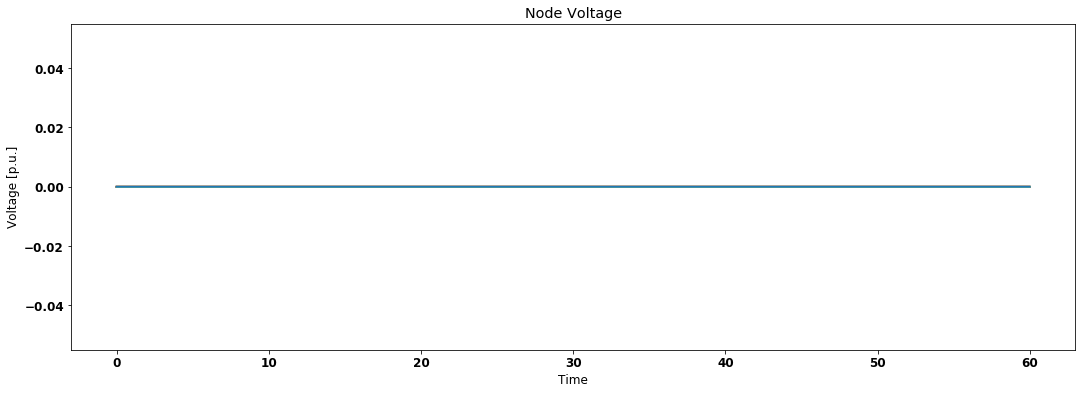

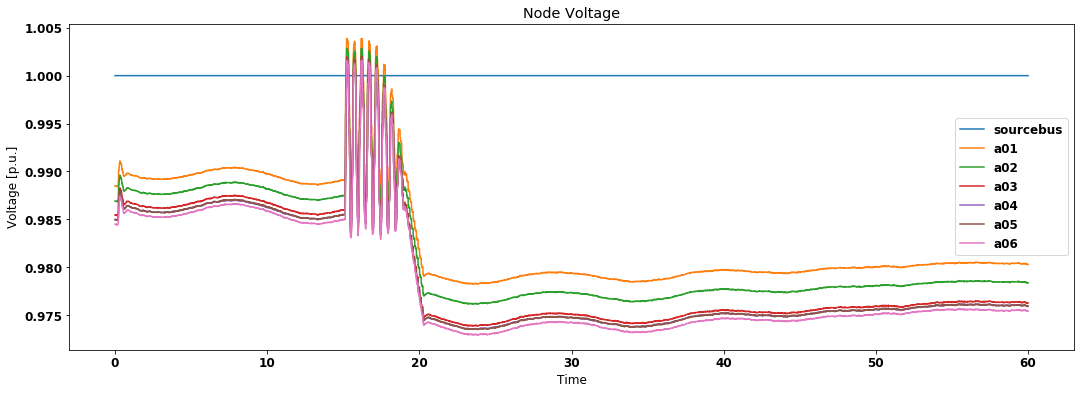

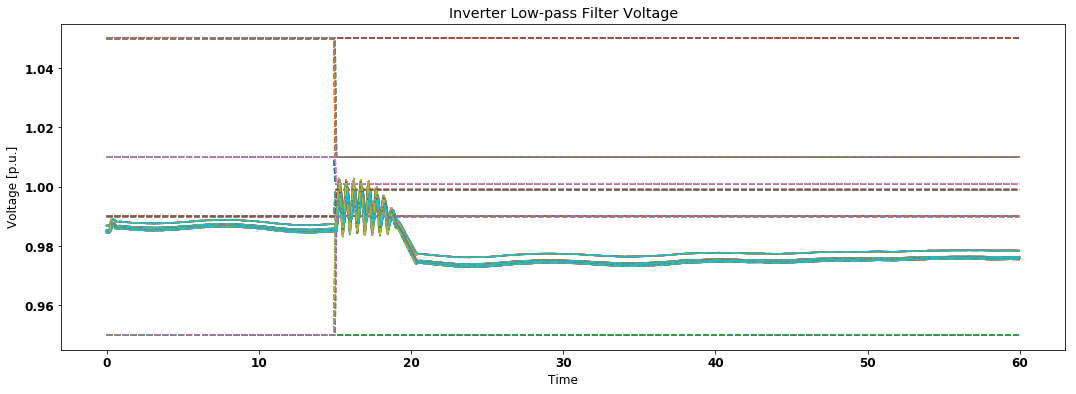

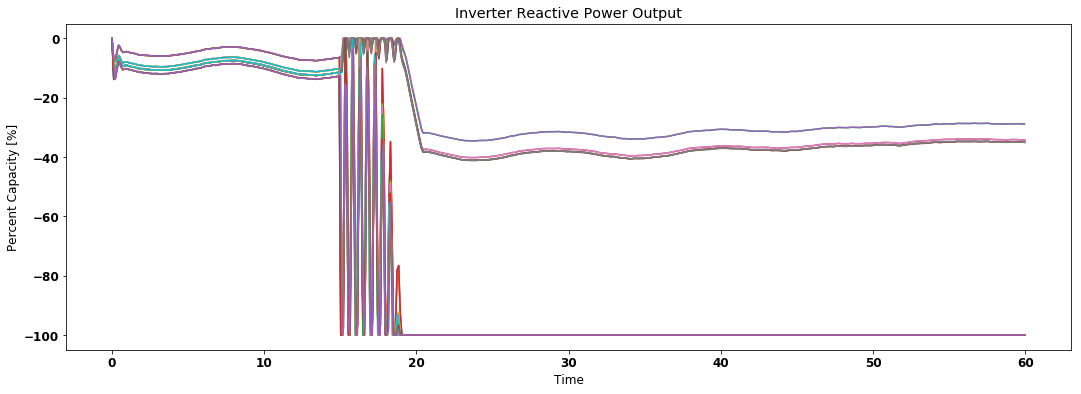

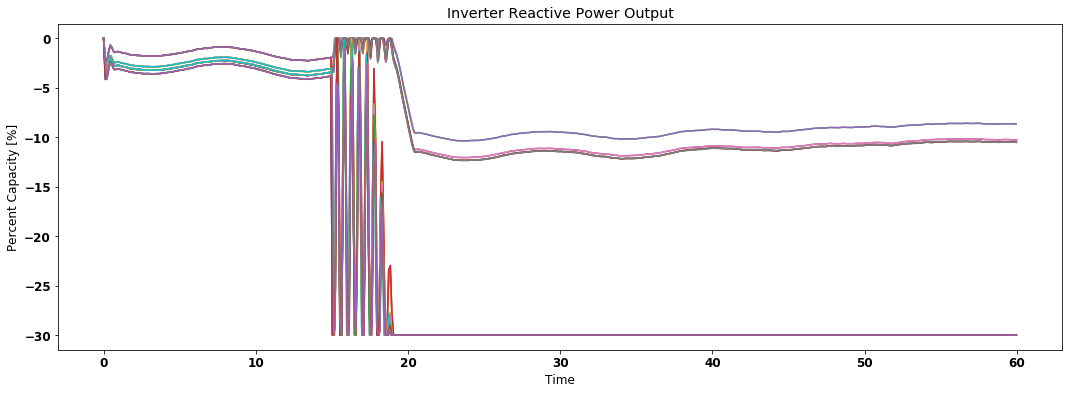

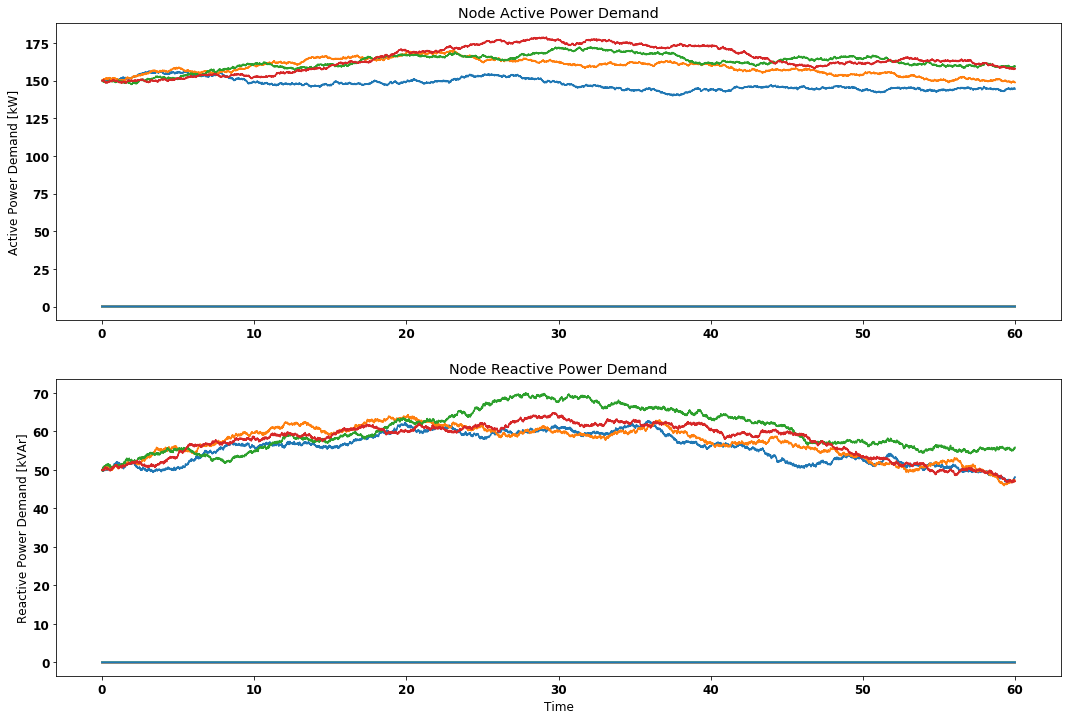

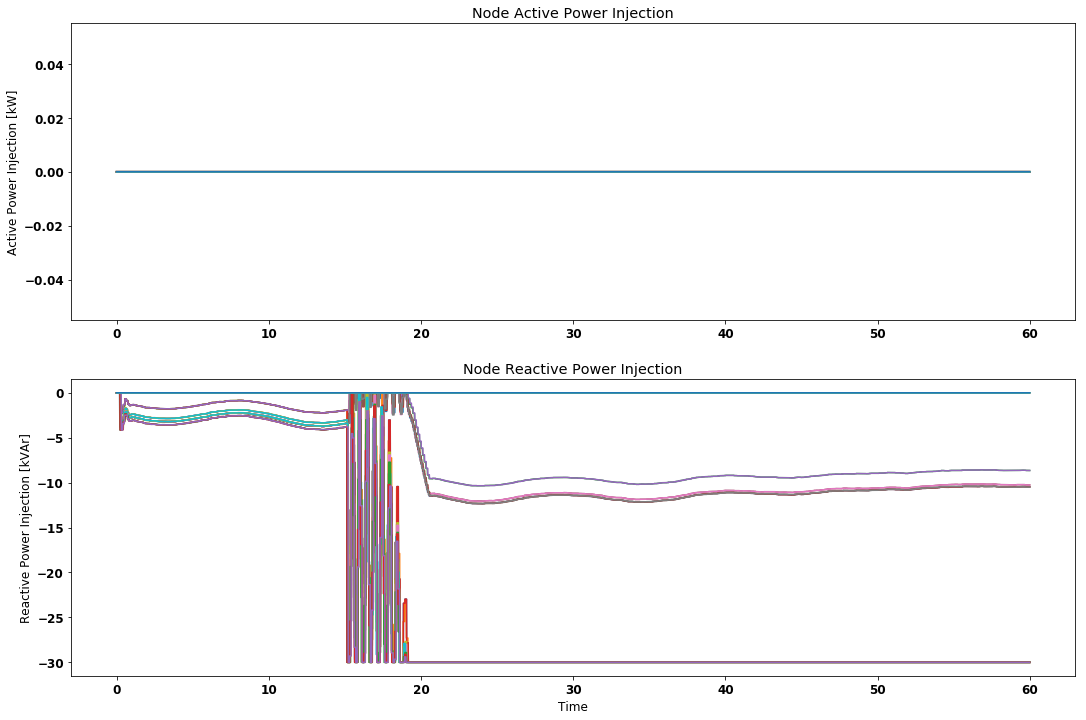

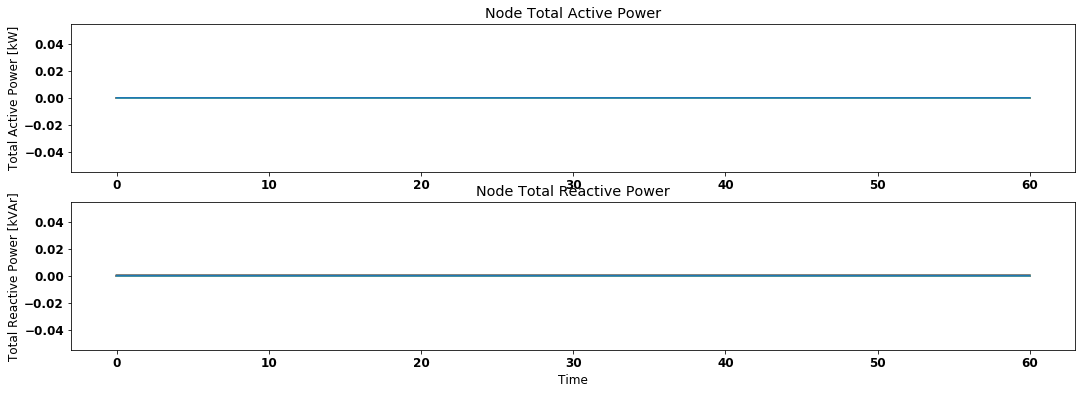

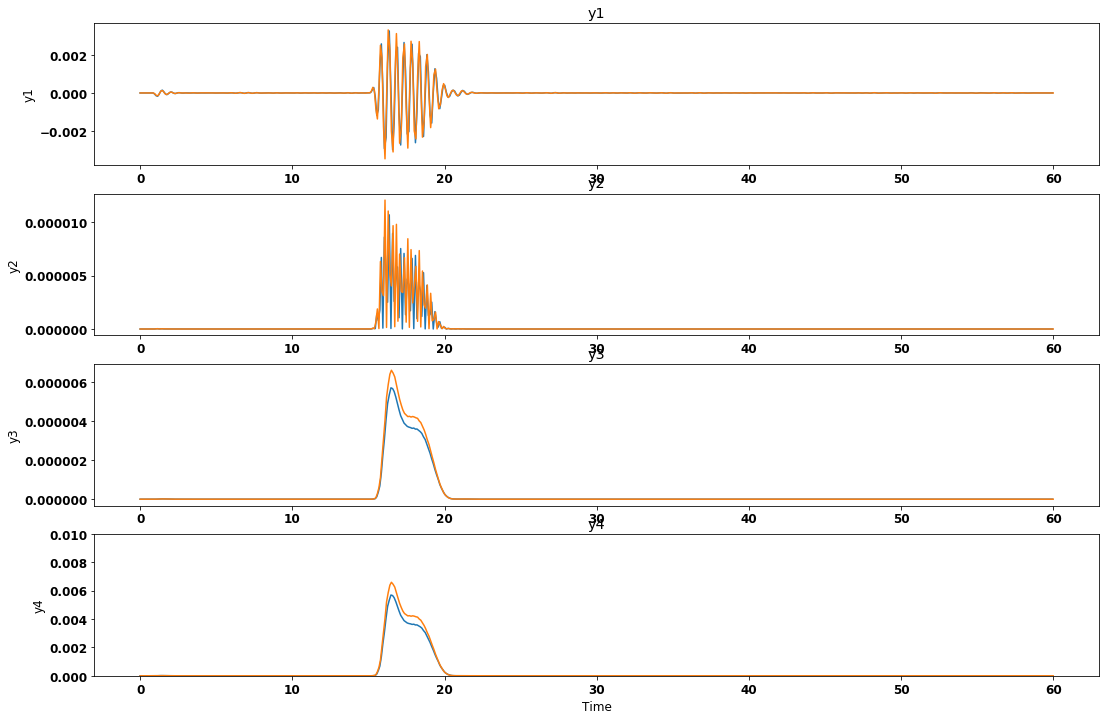

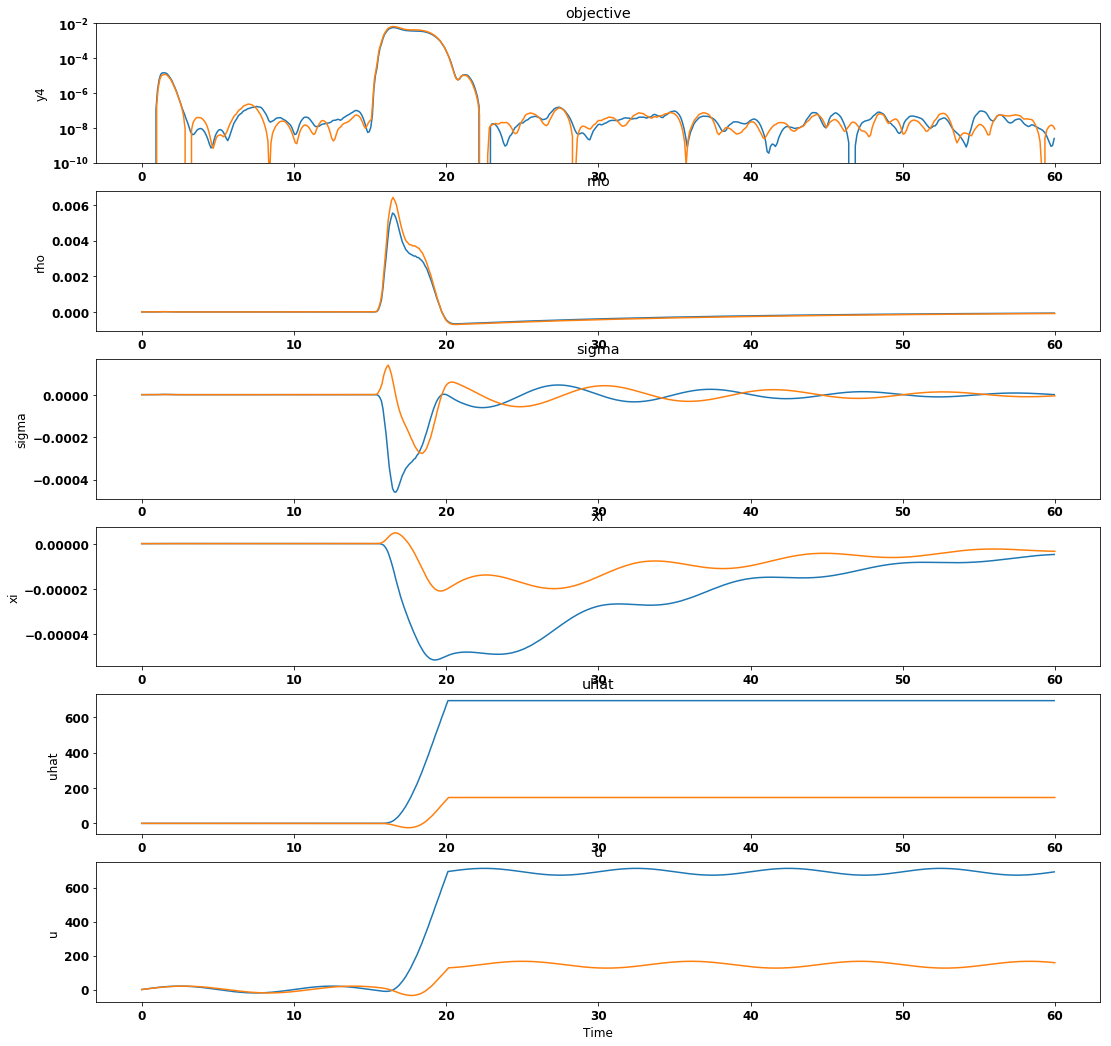

In [7]:
font = {'weight':'bold', 'size':12}

plt.rc('font', **font)

plotStartTimeStep = 0
plotEndTimeStep = len(time)

# plotStartTimeStep = 12*3600 + 1
# plotEndTimeStep = 12*3600 + 1 + 300

# time = np.arange(plotStartTimeStep,plotEndTimeStep)

# timehh = ((time-1)/3600).astype(int)
# timemm = ((time-1) - 3600*timehh)/60

# timeplot = timehh.astype(float) + timemm/100

fig = plt.figure(figsize=[18,6])
# for k1 in range(0,LoadBusVoltage.shape[1]):
for k1 in range(len(LoadBuses)):
#     plt.plot(time,LoadBusVoltage[:,k1])
    plt.plot(time,LoadBusVoltage[:,k1] - np.mean(LoadBusVoltage[:,k1]))
#     print(LoadBuses[k1])
plt.title('Node Voltage')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.show()


fig = plt.figure(figsize=[18,6])
# for k1 in range(0,LoadBusVoltage.shape[1]):
for k1 in range(len(AllBuses)):
    plt.plot(time,AllBusVoltage[:,k1],label=AllBuses[k1])
#     print(LoadBuses[k1])
plt.title('Node Voltage')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.legend()
plt.show()

fig = plt.figure(figsize=[18,6])
for k1 in range(0,len(inverterlist)):
#     plt.plot(inverterlist[k1].Vmeas[:])
    plt.plot(inverterlist[k1].timeop,inverterlist[k1].VBPhist[:],'--')
    plt.plot(inverterlist[k1].timeop,inverterlist[k1].Vmeas[:],'-.')
    plt.plot(inverterlist[k1].timeop,inverterlist[k1].Vlp[:])
# plt.ylim([0.85, 1.05])
plt.title('Inverter Low-pass Filter Voltage')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.show()

fig = plt.figure(figsize=[18,6])
for k1 in range(0,len(inverterlist)):
    plt.plot(inverterlist[k1].timeop,inverterlist[k1].reactive_power)
# plt.ylim([-100, 100])
plt.title('Inverter Reactive Power Output')
plt.xlabel('Time')
plt.ylabel('Percent Capacity [%]')
plt.show()

fig = plt.figure(figsize=[18,6])
for k1 in range(0,len(inverterlist)):
    plt.plot(inverterlist[k1].timeop,inverterlist[k1].qin)
# plt.ylim([-100, 100])
plt.title('Inverter Reactive Power Output')
plt.xlabel('Time')
plt.ylabel('Percent Capacity [%]')
plt.show()

# fig = plt.figure(figsize=[18,6])
# plt.plot(time,PloadTS[:,:])
# plt.plot(time,QloadTS[:,:])
# plt.title('Load Demands')
# plt.xlabel('Time')
# plt.ylabel('Percent Capacity [%]')
# plt.show()

fig = plt.figure(figsize=[18,12])
plt.subplot(2,1,1)
plt.plot(time,PloadTS[:,:])
plt.title('Node Active Power Demand')
# plt.xlabel('Time')
plt.ylabel('Active Power Demand [kW]')
plt.subplot(2,1,2)
plt.plot(time,QloadTS[:,:])
plt.title('Node Reactive Power Demand')
plt.xlabel('Time')
plt.ylabel('Reactive Power Demand [kVAr]')
plt.show()

# fig = plt.figure(figsize=[18,6])
# plt.plot(time,PinjTS[:,:])
# plt.plot(time,QinjTS[:,:])
# plt.title('Injection')
# plt.show()

fig = plt.figure(figsize=[18,12])
plt.subplot(2,1,1)
plt.plot(time,PinvTS[:,:])
plt.title('Node Active Power Injection')
# plt.xlabel('Time')
plt.ylabel('Active Power Injection [kW]')
plt.subplot(2,1,2)
plt.plot(time,QinvTS[:,:])
plt.title('Node Reactive Power Injection')
plt.xlabel('Time')
plt.ylabel('Reactive Power Injection [kVAr]')
plt.show()

# fig = plt.figure(figsize=[18,6])
# plt.plot(time,PtotalTS[:,:])
# plt.plot(time,QtotalTS[:,:])
# plt.title('Total')
# plt.show()

fig = plt.figure(figsize=[18,6])
plt.subplot(2,1,1)
plt.plot(time,PtotalTS[:,:])
plt.title('Node Total Active Power')
# plt.xlabel('Time')
plt.ylabel('Total Active Power [kW]')
plt.subplot(2,1,2)
plt.plot(time,QtotalTS[:,:])
plt.title('Node Total Reactive Power')
plt.xlabel('Time')
plt.ylabel('Total Reactive Power [kVAr]')
plt.show()

fig = plt.figure(figsize=[18,12])
plt.subplot(4,1,1)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].y1)
plt.title('y1')
# plt.xlabel('Time')
plt.ylabel('y1')
plt.subplot(4,1,2)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].y2)
plt.title('y2')
plt.ylabel('y2')
plt.subplot(4,1,3)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].y3)
plt.title('y3')
plt.ylabel('y3')
plt.subplot(4,1,4)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].y4)
plt.title('y4')
plt.xlabel('Time')
plt.ylabel('y4')
plt.ylim([1e-10, 1e-2])
plt.show()

fig = plt.figure(figsize=[18,18])
plt.subplot(6,1,1)
for k1 in range(len(esclist)):
    plt.semilogy(esclist[k1].timeop,esclist[k1].y4)
plt.title('objective')
plt.ylabel('y4')
plt.ylim([1e-10, 1e-2])
plt.subplot(6,1,2)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].rho)
plt.title('rho')
plt.ylabel('rho')
plt.subplot(6,1,3)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].sigma)
plt.title('sigma')
plt.ylabel('sigma')
plt.subplot(6,1,4)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].xi)
plt.title('xi')
plt.ylabel('xi')
plt.subplot(6,1,5)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].uhat)
plt.title('uhat')
plt.ylabel('uhat')
plt.subplot(6,1,6)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].u)
plt.title('u')
plt.xlabel('Time')
plt.ylabel('u')
plt.show()

# print(timeplot)


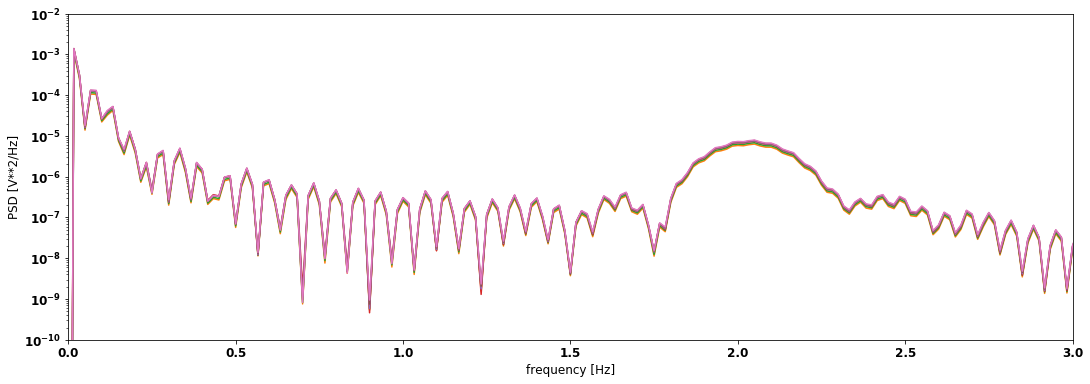

In [8]:
from scipy import signal
import matplotlib.pyplot as plt

fs = 100
N = len(time)

fig = plt.figure(figsize=[18,6])
for k1 in range(AllBusVoltage.shape[1]):
    x = AllBusVoltage[:,k1]
    f, Pxx_den = signal.periodogram(x, fs)
    plt.semilogy(f, Pxx_den)
    plt.xlim([0, 3])
    plt.ylim([1e-10, 1e-2])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [9]:
inverter_params = pd.read_csv('inverter_params.csv',header=0,index_col=0)

inverter_params['Toff'] = 1/100*np.floor(10*np.random.rand(inverter_params.shape[0]))

inverter_params['Toff'].loc[2]

0.09

[0.94 0.95 0.96 0.97 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06]


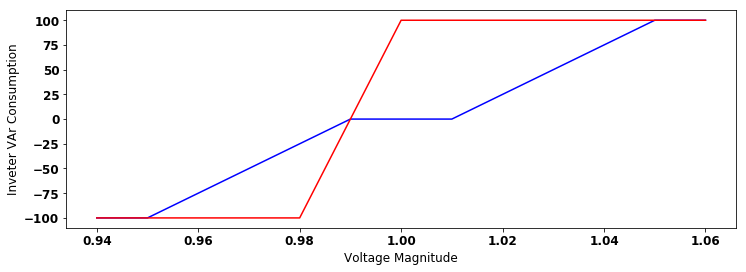

In [10]:
Vmag = np.arange(0.94,1.06,0.01)

print(Vmag)

VBP1 = np.array([0.95, 0.99, 1.01, 1.05])
VBP2 = np.array([0.99, 0.999, 1.001, 1.01])-0.01

Q1 = np.zeros(len(Vmag))
Q2 = np.zeros(len(Vmag))

# if Vcomp <= self.VBP[0]:
#     self.reactive_power[kt] = -100
# elif self.VBP[0] <= Vcomp <= self.VBP[1]:
#     self.reactive_power[kt] =100/(self.VBP[1] - self.VBP[0])*(Vcomp - self.VBP[1])
# elif self.VBP[1] <= Vcomp <= self.VBP[2]:
#     self.reactive_power[kt] = 0
# elif self.VBP[2] <= Vcomp <= self.VBP[3]:
#     self.reactive_power[kt] = 100/(self.VBP[3] - self.VBP[2])*(Vcomp - self.VBP[2])
# elif self.VBP[3] <= Vcomp:
#     self.reactive_power[kt] = 100

for k1 in range(0,len(Vmag)):
    if Vmag[k1] <= VBP1[0]:
        Q1[k1] = -100
    elif VBP1[0] <= Vmag[k1] <= VBP1[1]:
        Q1[k1] = 100/(VBP1[1] - VBP1[0])*(Vmag[k1] - VBP1[1])
    elif VBP1[1] <= Vmag[k1] <= VBP1[2]:
        Q1[k1] = 0
    elif VBP1[2] <= Vmag[k1] <= VBP1[3]:
        Q1[k1] = 100/(VBP1[3] - VBP1[2])*(Vmag[k1] - VBP1[2])
    elif VBP1[3] <= Vmag[k1]:
        Q1[k1] = 100
        
for k1 in range(0,len(Vmag)):
    if Vmag[k1] <= VBP2[0]:
        Q2[k1] = -100
    elif VBP2[0] <= Vmag[k1] <= VBP2[1]:
        Q2[k1] = 100/(VBP2[1] - VBP2[0])*(Vmag[k1] - VBP2[1])
    elif VBP2[1] <= Vmag[k1] <= VBP2[2]:
        Q2[k1] = 0
    elif VBP2[2] <= Vmag[k1] <= VBP2[3]:
        Q2[k1] = 100/(VBP2[3] - VBP2[2])*(Vmag[k1] - VBP2[2])
    elif VBP2[3] <= Vmag[k1]:
        Q2[k1] = 100
        
fig = plt.figure(figsize=[12, 4])

plt.plot(Vmag,Q1,'b-')
plt.plot(Vmag,Q2,'r-')
# plt.xlim([0, 3])
# plt.ylim([1e-10, 1e-2])
plt.xlabel('Voltage Magnitude')
plt.ylabel('Inveter VAr Consumption')

plt.show()

fig.savefig('/home/michael/Desktop/temp/inverter_vvc_cruve.png')

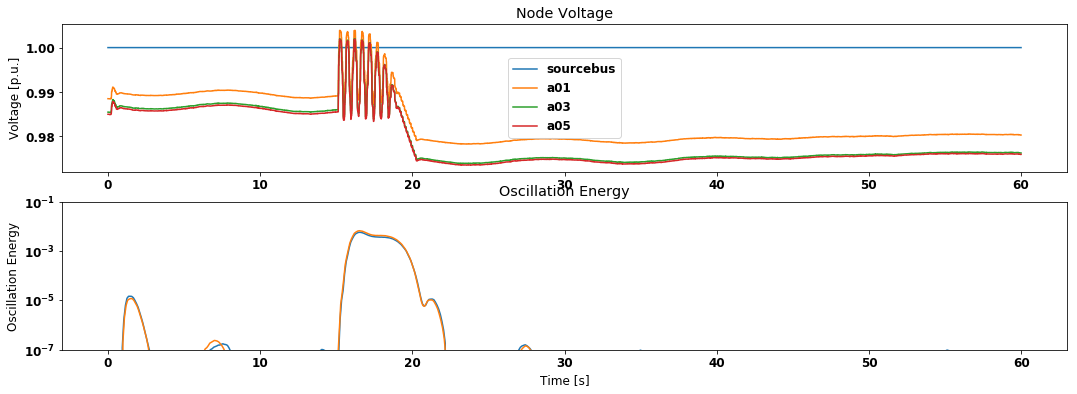

In [11]:
fig = plt.figure(figsize=[18,6])
# for k1 in range(0,LoadBusVoltage.shape[1]):
plt.subplot(2,1,1)
plt.plot(time,AllBusVoltage[:,0],label=AllBuses[0])
plt.plot(time,AllBusVoltage[:,1],label=AllBuses[1])
plt.plot(time,AllBusVoltage[:,3],label=AllBuses[3])
plt.plot(time,AllBusVoltage[:,5],label=AllBuses[5])
plt.title('Node Voltage')
# plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.legend()
plt.subplot(2,1,2)
for k1 in range(len(esclist)):
    plt.semilogy(esclist[k1].timeop,esclist[k1].y4)
plt.title('Oscillation Energy')
plt.xlabel('Time [s]')
plt.ylabel('Oscillation Energy')
plt.ylim([1e-7, 1e-1])

plt.show()

# fig.savefig('/home/michael/Desktop/temp/attack_no_es.png')

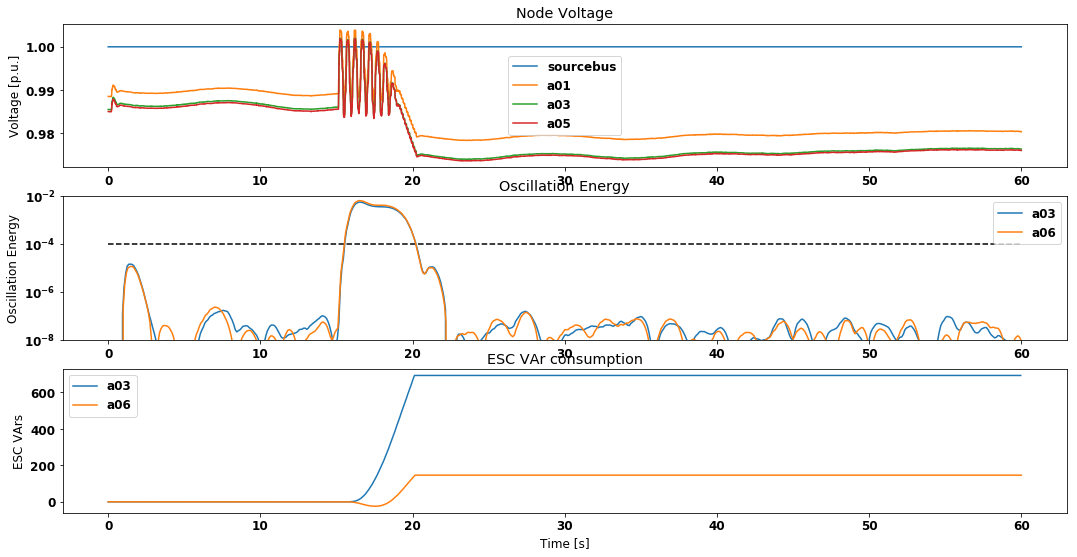

In [12]:
fig = plt.figure(figsize=[18,9])
# for k1 in range(0,LoadBusVoltage.shape[1]):
plt.subplot(3,1,1)
plt.plot(time,AllBusVoltage[:,0],label=AllBuses[0])
plt.plot(time,AllBusVoltage[:,1],label=AllBuses[1])
plt.plot(time,AllBusVoltage[:,3],label=AllBuses[3])
plt.plot(time,AllBusVoltage[:,5],label=AllBuses[5])
plt.title('Node Voltage')
# plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.legend()

plt.subplot(3,1,2)
plt.semilogy(esclist[0].timeop,1e-4*np.ones(len(esclist[0].timeop)),'k--')
for k1 in range(len(esclist)):
    plt.semilogy(esclist[k1].timeop,esclist[k1].y4,label=esclist[k1].nodename)
plt.title('Oscillation Energy')
# plt.xlabel('Time')
plt.ylabel('Oscillation Energy')
plt.legend()
plt.ylim([1e-8, 1e-2])


plt.subplot(3,1,3)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].uhat,label=esclist[k1].nodename)
plt.title('ESC VAr consumption')
plt.xlabel('Time [s]')
plt.ylabel('ESC VArs')
plt.legend()

plt.show()

fig.savefig('/home/michael/Desktop/temp/attack_es_1e4.png')

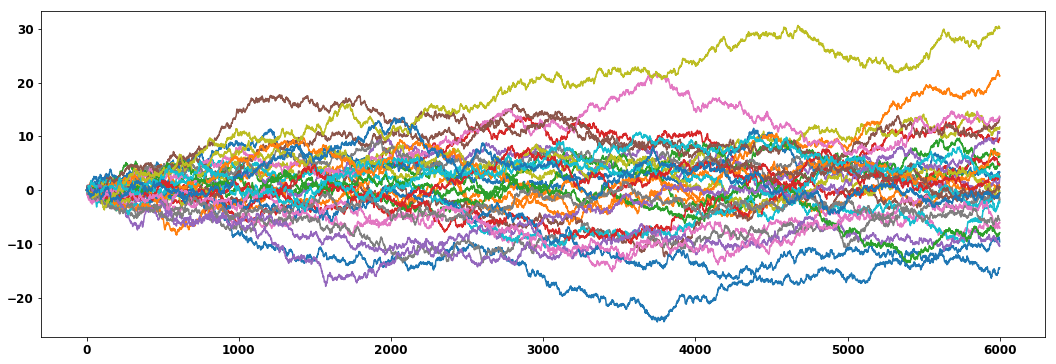

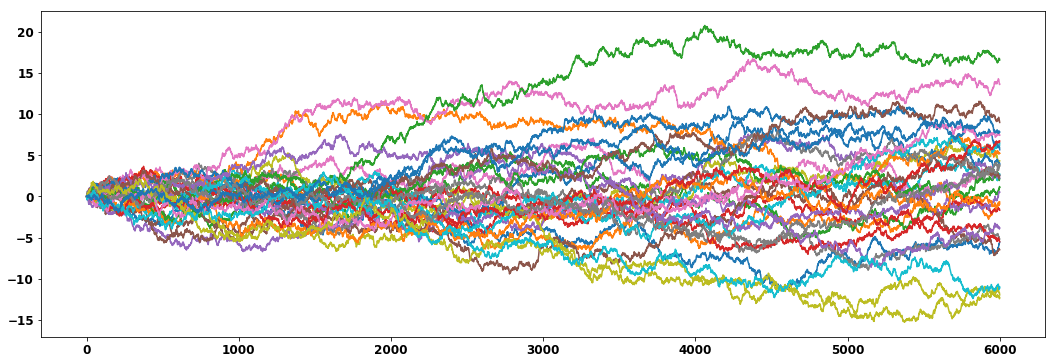

In [13]:
fig = plt.figure(figsize=[18,6])
plt.plot(Prw.T)

fig = plt.figure(figsize=[18,6])
plt.plot(Qrw.T)

plt.show()